# RGI10 (Asia North)

F. Maussion & S. Galos, June-December 2021

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, open_zip_shapefile, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 10

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '10_rgi60_NorthAsia.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

# OK path to file
box_file = os.path.join(support_dir, 'rgi10_boxes.zip')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, df_cat = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
357,182,156.0,Kapustin,Khromova,2006,Siberian Mountains,2003,2003,2003
382,80,61.0,Kapustin,Khromova,2006,Russian Glaciers (exact boundaries of RC to be...,2001,2001,2001
408,138,54.6,Muraviev,Khromova,2007,Russian Glaciers (exact boundaries of RC to be...,2000,2000,2000
506,79,88.6,Muraviev,Khromova,2008,Siberian Mountains,2004,2004,2004
507,206,176.5,Muraviev,Khromova,2008,Siberian Mountains,2004,2004,2004
570,690,436.6,Pan,Kamp,2013,Mongolia,1989,1989,1991
571,716,429.1,Pan,Kamp,2013,Mongolia,2000,1998,2001
572,668,367.5,Pan,Kamp,2013,Mongolia,2011,2010,2011
583,285,187.7,"Guo, Liu",Liu,2014,China,2006,2006,2008


- 636 is RGI6
- 752 is GAMDAMv2 - we use it
- 726 is a mapping of a few remaining nominal glaciers on three De Long Islands
- 761 is an update of the Barr inventory for Kamchatka **needs to be replacec once new outlines are ingested**
- 763 are "new" glaciers in Japan ;-) 

In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [7]:
glims_rgi = shp.loc[shp.subm_id.isin([636])].copy()
glims_rgi['is_rgi6'] = True
s_761 = shp.loc[shp.subm_id.isin([761])].copy()
s_761['is_rgi6'] = False
s_752 = shp.loc[shp.subm_id.isin([752])].copy()
s_752['is_rgi6'] = False
s_726 = shp.loc[shp.subm_id.isin([726])].copy()
s_726['is_rgi6'] = False
s_763 = shp.loc[shp.subm_id.isin([763])].copy()
s_763['is_rgi6'] = False

In [8]:
# Preselected areas to remove
box = open_zip_shapefile(support_dir + '/rgi10_boxes.zip')

In [9]:
# Remove the new regions from rgi
rp = glims_rgi.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = glims_rgi.index
difference = gpd.overlay(rp, box, how='difference')
glims_rgi = glims_rgi.loc[difference['orig_index']].copy()

In [10]:
# Size filter?
needs_size_filter(glims_rgi)

False

In [11]:
print(len(s_761))
s_761 = size_filter(s_761)
print(len(s_761))

2491
2491


In [12]:
print(len(s_752))
s_752 = size_filter(s_752)
print(len(s_752))

3001
3001


In [13]:
print(len(s_726))
s_726 = size_filter(s_726)
print(len(s_726))

12
12


In [14]:
print(len(s_763))
s_763 = size_filter(s_763)
print(len(s_763))

5
5


In [15]:
rgi7 = pd.concat([glims_rgi, s_761, s_752, s_726, s_763])

### Some sanity checks 

In [16]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [17]:
rgi7 = correct_geoms(rgi7)

Found 68 invalid geometries out of 7155. Correcting...
High correction: 423531. Area diff: -1474.8597890146193 m2 (-0.4518%) Smaller than 0.1 km2. Ignoring.
After correction, 0 geometries are still invalid.
Area changed by -1474.9 m2 (-0.0001%)


In [18]:
needs_size_filter(rgi7)

False

In [19]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
636,1646,1646
761,2491,2491
752,3001,3001
726,12,12
763,5,5


In [20]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

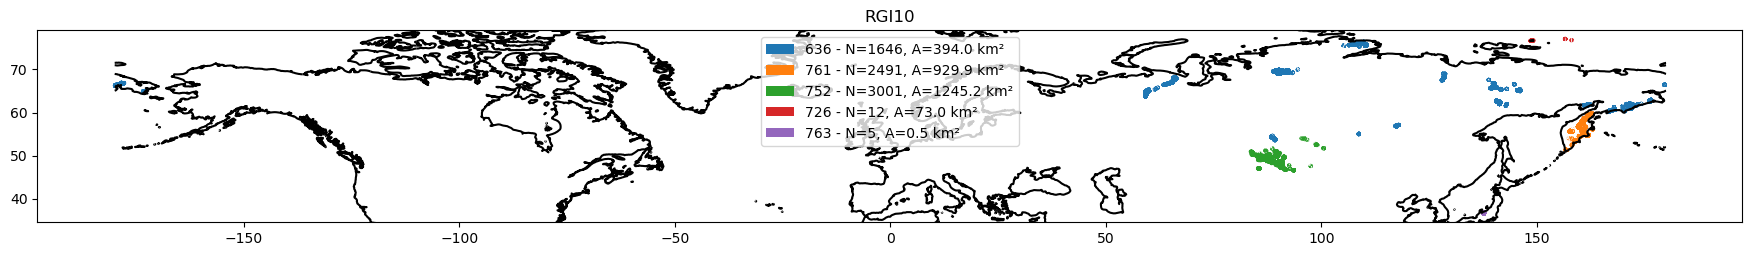

In [21]:
plot_map(rgi7, reg, figsize=(22, 10), linewidth=3, loc='upper center', aspect='equal')

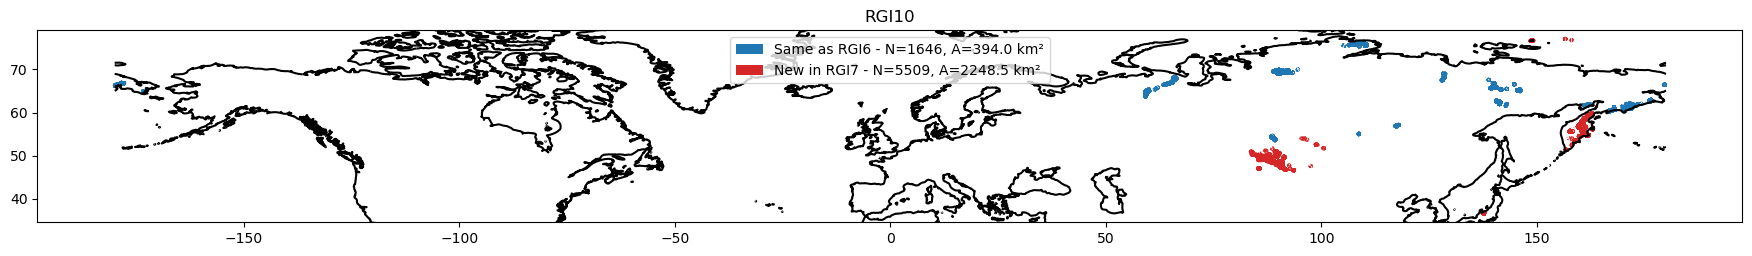

In [22]:
plot_map(rgi7, reg, figsize=(22, 10), linewidth=3, loc='upper center', is_rgi6=True, aspect='equal')

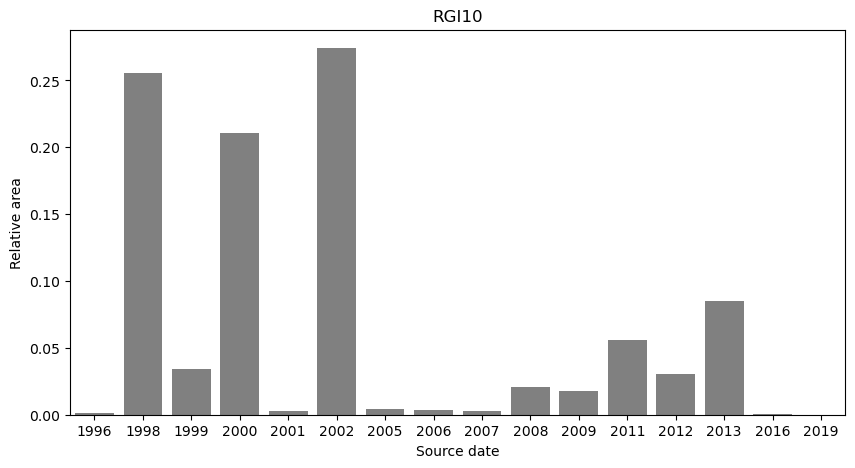

In [23]:
plot_date_hist(rgi7, reg)

### Text for github

In [24]:
fgh = sdf.T
fgh

subm_id,636,761,752,726,763
N,1646,2491,3001,12,5
A,394.0,929.9,1245.2,73.0,0.5
analysts,"Cogley, Earl, Gardner, Raup","Barr, Khromova, Muraviev, Paul, Rastner",Sakai,Kochtitzky,Arie
submitters,Cogley,Paul,Sakai,Kochtitzky,Arie
release_date,2015,2022,2018,2021,2022
geog_area,Randolph Glacier Inventory; Umbrella RC for me...,Various (GlobGlacier),Asia,Canada,Japan
src_date_mode,2013,2000,2002,1999,2019
src_date_min,1999,2000,1996,1999,2016
src_date_max,2013,2016,2008,2000,2019


In [25]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 636                                                                    | 761                                     | 752    | 726        | 763   |
|:--------------|:-----------------------------------------------------------------------|:----------------------------------------|:-------|:-----------|:------|
| N             | 1646                                                                   | 2491                                    | 3001   | 12         | 5     |
| A             | 394.0                                                                  | 929.9                                   | 1245.2 | 73.0       | 0.5   |
| analysts      | Cogley, Earl, Gardner, Raup                                            | Barr, Khromova, Muraviev, Paul, Rastner | Sakai  | Kochtitzky | Arie  |
| submitters    | Cogley                                                                 | Paul                                    | Sakai  | Kochtitzky | Arie  |
| release_date  | 2015

## Write out and tar 

In [26]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI10/
RGI10/RGI10.prj
RGI10/RGI10.cpg
RGI10/RGI10.shx
RGI10/RGI10.dbf
RGI10/RGI10.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI10.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI10'], returncode=0)


## Consistency check with RGI6 

In [28]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [29]:
len(rgi7), len(rgi6)

(7150, 5151)

Test the areas:

In [30]:
rgi6['area'] = rgi6.to_crs({'proj':'cea'}).area 

In [31]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['area'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['area'].sum() - rgi7['area'].sum()) * 1e-6)

Area RGI7a (km2) 2642.0550943785124
Area RGI6 (km2) 2410.021788898029
diff areas RGI6 - RGI7 computed by us (km2) -232.03330548048305


In [32]:
# Remove the ids
rp = rgi6.representative_point()
rp = rp.to_frame('geometry')
rp['orig_index'] = rgi6.index

difference = gpd.overlay(rp, box, how='difference')
rgi6_old = rgi6.loc[difference['orig_index']].copy()
difference = gpd.overlay(rp, box, how='intersection')
rgi6_new = rgi6.loc[difference['orig_index']].copy()
assert len(rgi6_new) + len(rgi6_old) == len(rgi6)

In [33]:
print(f'N1 = {len(rgi6_old)} , N2 = {len(glims_rgi)}')
print('Area RGI7 (km2)', glims_rgi['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6_old['area'].sum() * 1e-6)
print('diff', (rgi6_old['area'].sum() - glims_rgi['area'].sum()) * 1e-6)

N1 = 1646 , N2 = 1646
Area RGI7 (km2) 394.0329721890614
Area RGI6 (km2) 394.0330784789445
diff 0.00010628988313674926


### With FP inv  

In [34]:
support_dir = os.path.join(data_dir, 'l0_support_data')
gamdam_dir = os.path.join(support_dir, 'gamdam')

In [35]:
fp = open_zip_shapefile(support_dir + '/kamchatka_topos_alos_dem_30m_utm57N_b_footprints.zip')
fp['area'] = fp.to_crs({'proj':'cea'}).area 

In [37]:
print(f'NFP = {len(fp)} , NRGI7 = {len(s_761)}')
print('Area RGI7 (km2)', s_761['area'].sum() * 1e-6)
print('Area FP (km2)', fp['area'].sum() * 1e-6)
print('diff', (fp['area'].sum() - s_761['area'].sum()) * 1e-6)

NFP = 2491 , NRGI7 = 2491
Area RGI7 (km2) 929.8974660094616
Area FP (km2) 929.8979188856181
diff 0.0004528761564493179


### With GAMDAM 

In [38]:
# Region file to select from gamdam
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions', '00_rgi70_O1Regions.shp')

In [39]:
# specify path to reference data set
import glob
from utils import open_zip_shapefile
gam_files = glob.glob(gamdam_dir + '/*.zip')
df_ref = []
for gf in gam_files:
    df_ref.append(open_zip_shapefile(gf))

df_ref = pd.concat(df_ref).reset_index()

In [40]:
# Calculate representative points for reference data
ref_rp = df_ref.representative_point()

# Make a dataframe out of it and add the original index to recover it later
ref_rp = ref_rp.to_frame('geometry')
ref_rp['orig_index'] = df_ref.index

# Read region file
reg_f = gpd.read_file(reg_file)

# Make the overlay with the RGI region of interest -> get the rep. points which are located inside the region boundaries
ref_intersect = gpd.overlay(ref_rp, reg_f.loc[reg_f.RGI_CODE == f'{reg:02d}'], how='intersection')

# Now select the entries which intersect from the original shape file (-> extract the polygons) 
df_ref = df_ref.loc[ref_intersect['orig_index'].values].copy()

In [41]:
df_ref['area'] = df_ref.to_crs({'proj':'cea'}).area 

In [42]:
print(f'Nref = {len(df_ref)} , NRGI7 = {len(s_752)}')
print('Area RGI7 (km2)', s_752['area'].sum() * 1e-6)
print('Area ref (km2)', df_ref['area'].sum() * 1e-6)
print('diff', (df_ref['area'].sum() - s_752['area'].sum()) * 1e-6)

Nref = 3001 , NRGI7 = 3001
Area RGI7 (km2) 1245.1650982874623
Area ref (km2) 1245.1653133866212
diff 0.00021509915876388548
